In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, make_scorer
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV , LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer




## 1.1

<Axes: >

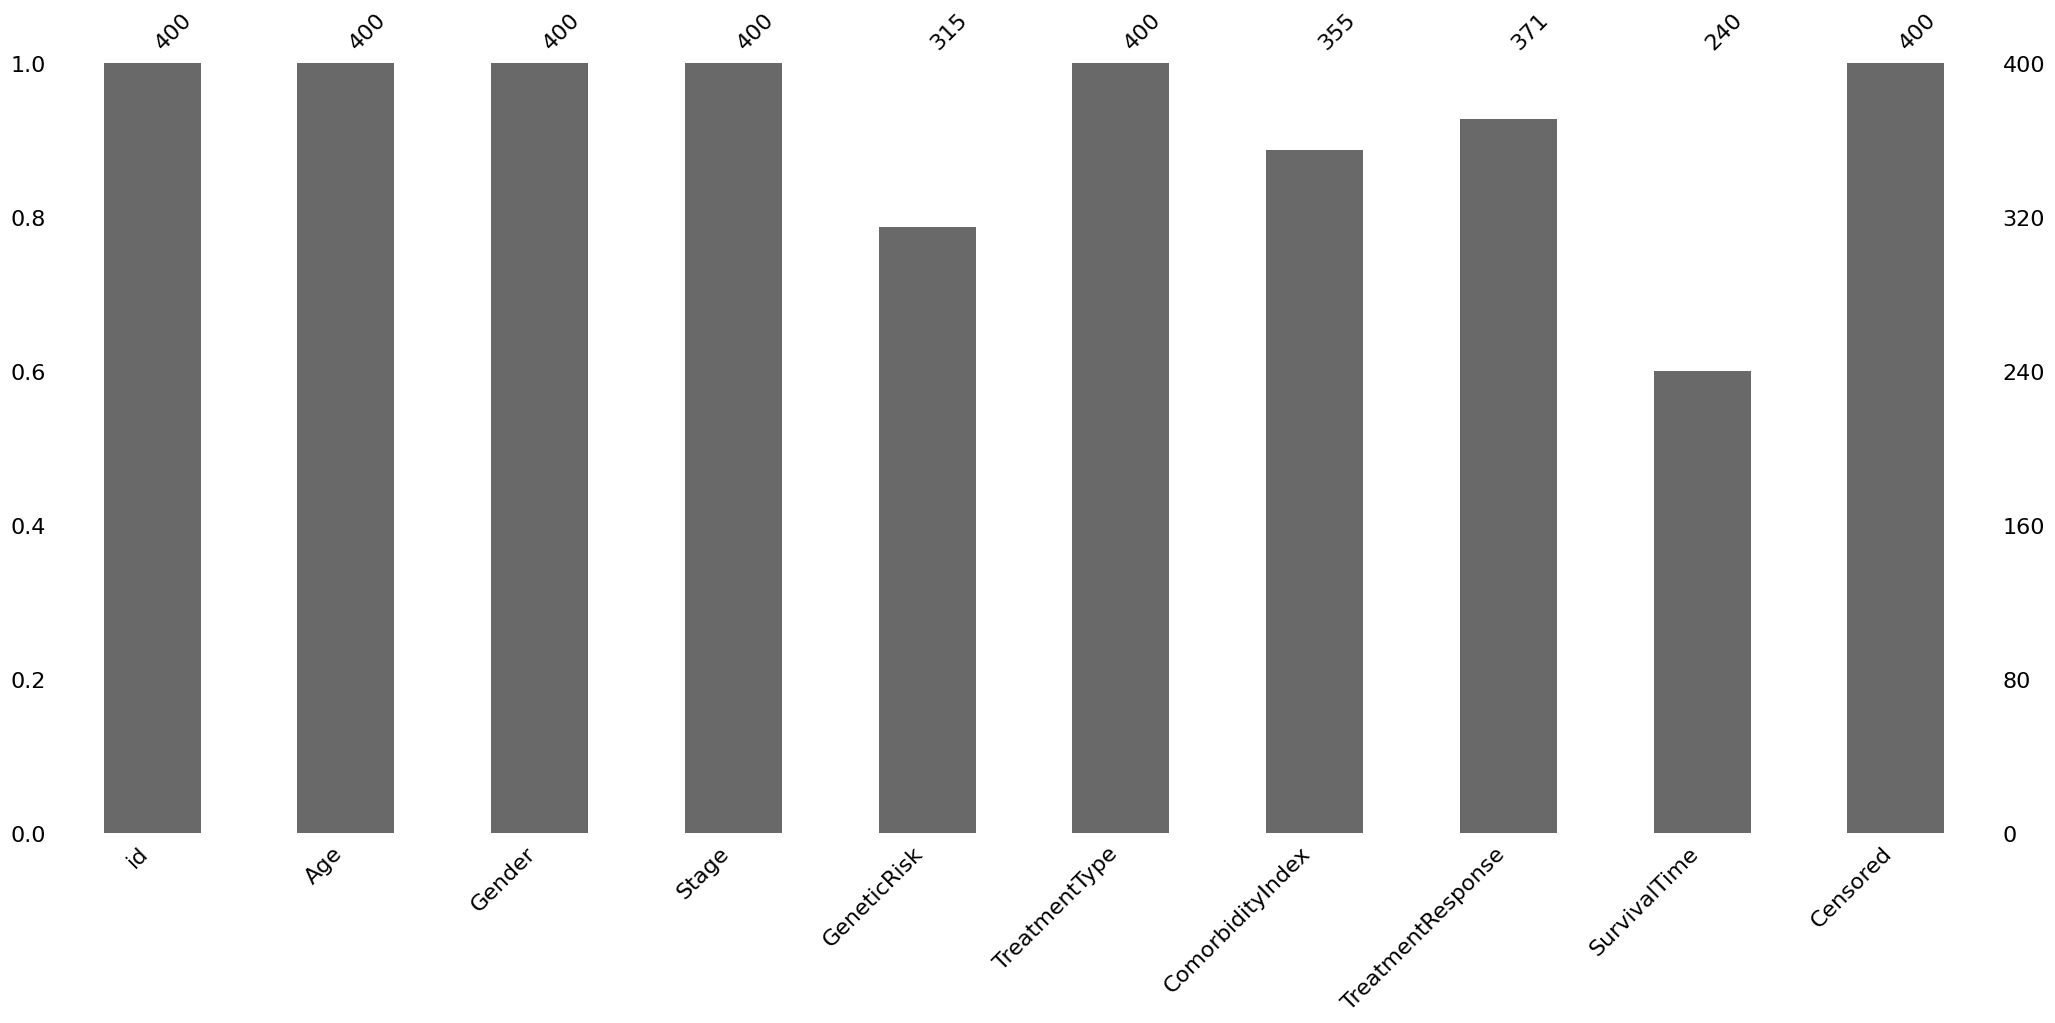

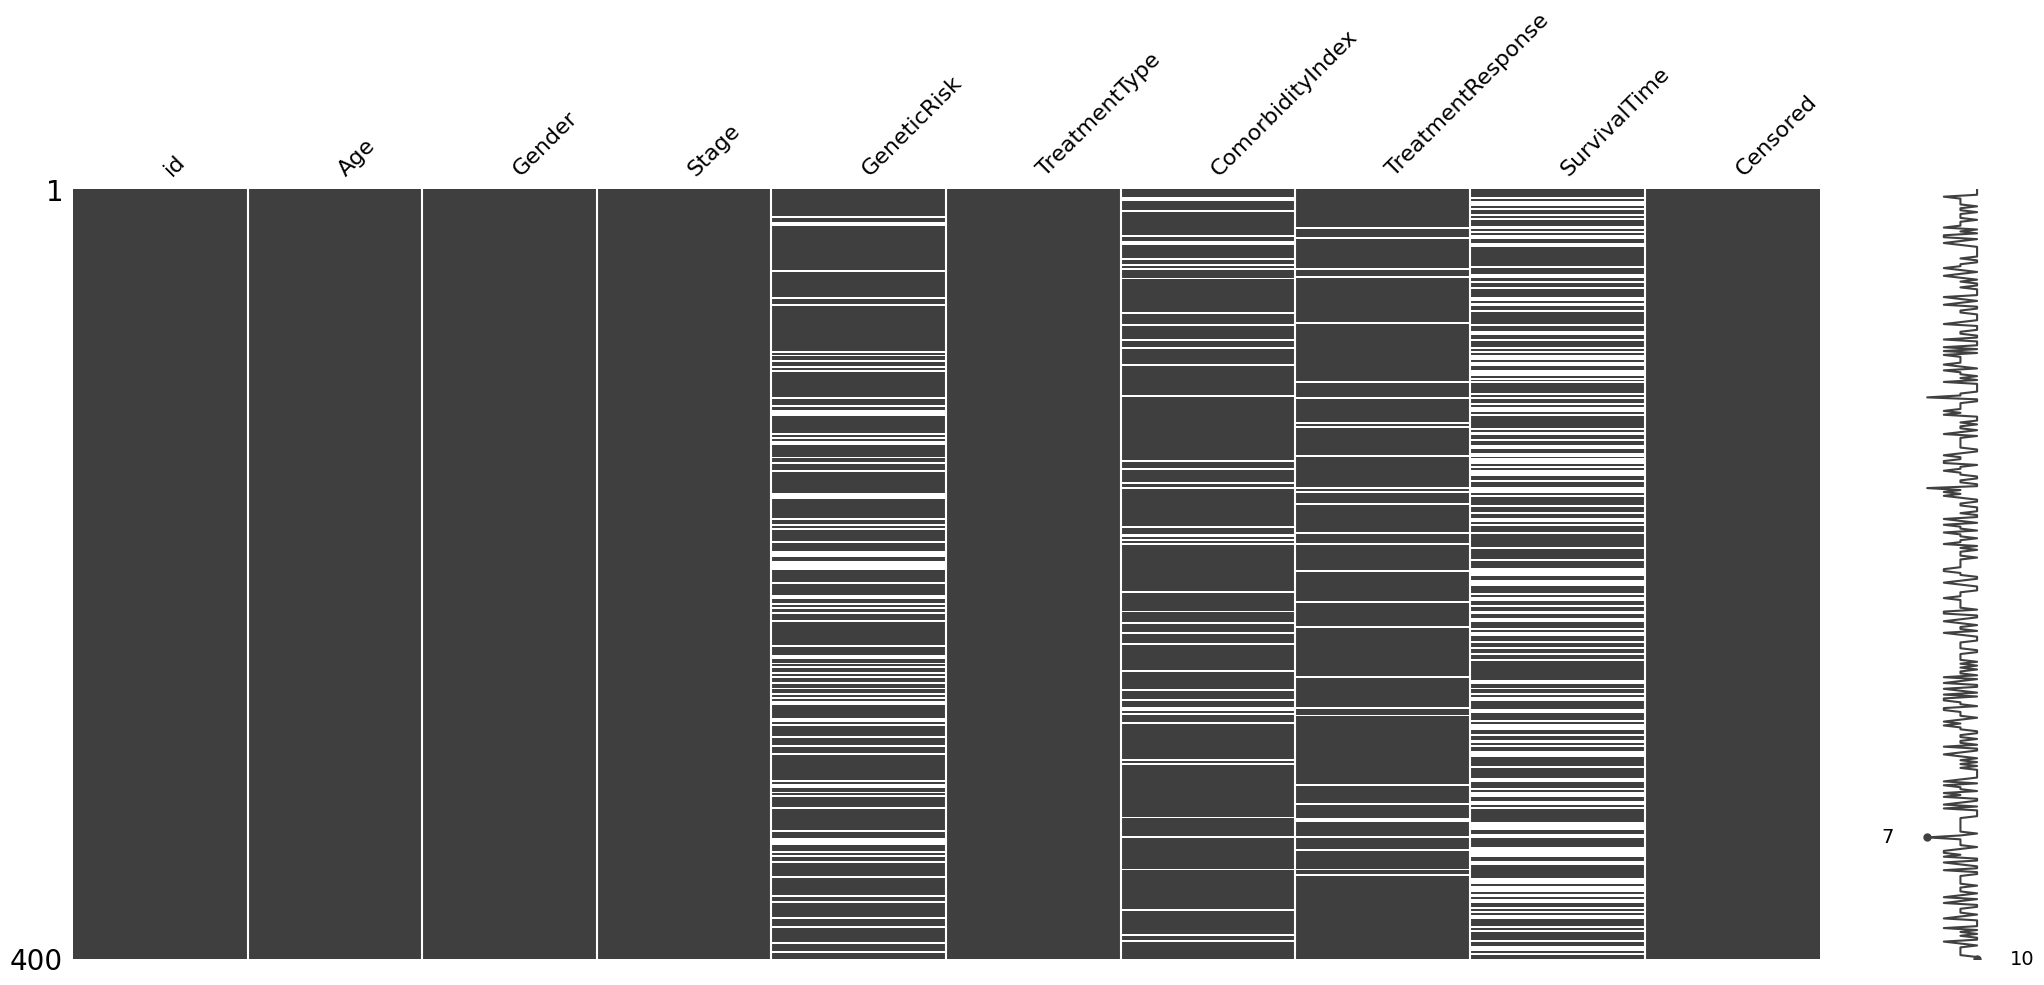

In [ ]:
raw_data = pd.read_csv("train_data.csv")

msno.bar(raw_data)
#msno.heatmap(data)
msno.matrix(raw_data)
#msno.dendrogram(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Remaining data points: 161


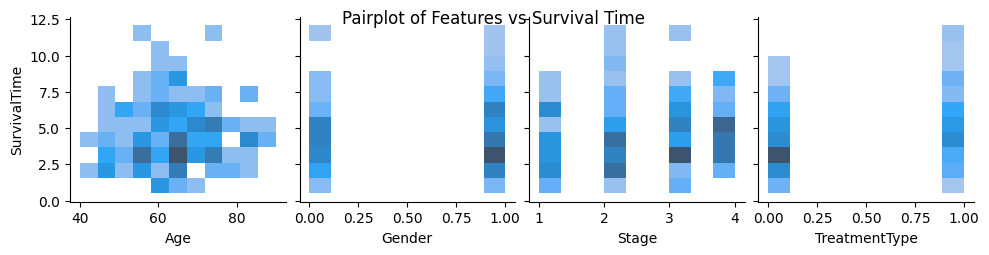

In [ ]:

# Drop rows with missing survival time first
filt_data = raw_data.dropna(subset=["SurvivalTime"])


# Drop columns containing missing data
filt_data = filt_data.dropna(axis=1)

# Remove the 'id' column
filt_data = filt_data.drop(columns=["id"])


# Filter out censored data points
filtered_data = filt_data[filt_data["Censored"] == 0]



# Check how many data points are left
remaining_points = len(filtered_data)

print(f"Remaining data points: {remaining_points}")
#msno.matrix(filtered_data)


# Pairplot for the features and target variable
sns.pairplot(filtered_data, y_vars=["SurvivalTime"],
             x_vars=["Age", "Gender", "Stage", "TreatmentType"],
             kind="hist")
plt.suptitle("Pairplot of Features vs Survival Time")
plt.show()




In [ ]:
def prepare_xy(data):
    # Define the feature matrix X and target vector y
    X = data.drop(columns=["SurvivalTime"])
    y = data["SurvivalTime"]
    return X, y

X_un, y_un = prepare_xy(filtered_data)

# Display the shapes of X and y
X_un.shape, y_un.shape


((161, 5), (161,))

In [ ]:

def split_data(X, y):
    # Split the dataset into train and test sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

    # Separate the censored column
    c_train = X_train["Censored"]
    c_test = X_test["Censored"]
    X_train = X_train.drop(columns=["Censored"])
    X_test = X_test.drop(columns=["Censored"])
    return X_train, X_test, y_train, y_test, c_train, c_test

X_train, X_test, y_train, y_test, c_train, c_test = split_data(X_un, y_un)

# cMSE error metric
def error_metric(y, y_hat, c):
    """
    For censored cases this function ensures that only underestimation of the survival time is penalized,
    because we cannot penalize overestimation of the survival time for censored cases since the true value is unknown.
    """
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]


## 1.2 Baseline model

In [ ]:

def Cross_val(pipeline, X_train, y_train, c_train, n_splits=5):
    # Shuffle the training data
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
        # Use iloc for positional indexing if X_train is a pandas DataFrame
    if isinstance(X_train, (pd.DataFrame, pd.Series)):
        X_train = X_train.iloc[indices]
        y_train = y_train.iloc[indices]
        c_train = c_train.iloc[indices]
    else:
        # If not pandas, assume NumPy and index directly
        X_train = X_train[indices]
        y_train = y_train[indices]
        c_train = c_train[indices]


    # Split data into n_splits folds
    fold_size = len(X_train) // n_splits
    cv_scores = []

    for fold in range(n_splits):
        # Create validation fold
        start = fold * fold_size
        end = start + fold_size if fold != n_splits - 1 else len(X_train)  # Handle remainder
        X_val = X_train[start:end]
        y_val = y_train[start:end]
        c_val = c_train[start:end]

        # Create training folds by excluding the validation fold
        X_train_fold = pd.concat([X_train[:start], X_train[end:]]) if isinstance(X_train, pd.DataFrame) else np.concatenate((X_train[:start], X_train[end:]))
        y_train_fold = pd.concat([y_train[:start], y_train[end:]]) if isinstance(y_train, pd.Series) else np.concatenate((y_train[:start], y_train[end:]))

        # Train the model on the training folds
        pipeline.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_val_pred = pipeline.predict(X_val)

        # Calculate the cMSE for the fold
        fold_cMSE = error_metric(y_val, y_val_pred, c_val)
        cv_scores.append(fold_cMSE)

    # Calculate mean and std of cross-validation scores
    cv_cMSE_mean = np.mean(cv_scores)
    cv_cMSE_std = np.std(cv_scores)

    return cv_cMSE_mean, cv_cMSE_std

In [ ]:
# Pipeline with a StandardScaler and LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

def baseline_model(pipeline, X_train, y_train, X_test, y_test, c_train, c_test):

    cv_cMSE_mean, cv_cMSE_std = Cross_val(pipeline, X_train, y_train, c_train, n_splits=5)

    # Train the model on the full training data
    pipeline.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_test_pred = pipeline.predict(X_test)
    test_cmse = error_metric(y_test, y_test_pred, c_test)

    # Display cross-validation results and test set performance
    return y_test_pred,{
        "Cross-Validation cMSE (mean)": cv_cMSE_mean,
        "Cross-Validation cMSE (std)": cv_cMSE_std,
        "Test Set cMSE": test_cmse,
        "Training Data Points": len(X_train),
        "Test Data Points": len(X_test)
    }


y_test_pred, baseline_results = baseline_model(pipeline, X_train, y_train, X_test, y_test, c_train, c_test)


print(baseline_results)


{'Cross-Validation cMSE (mean)': 4.4908435769424075, 'Cross-Validation cMSE (std)': 1.9970152130446666, 'Test Set cMSE': 3.757100793186035, 'Training Data Points': 128, 'Test Data Points': 33}


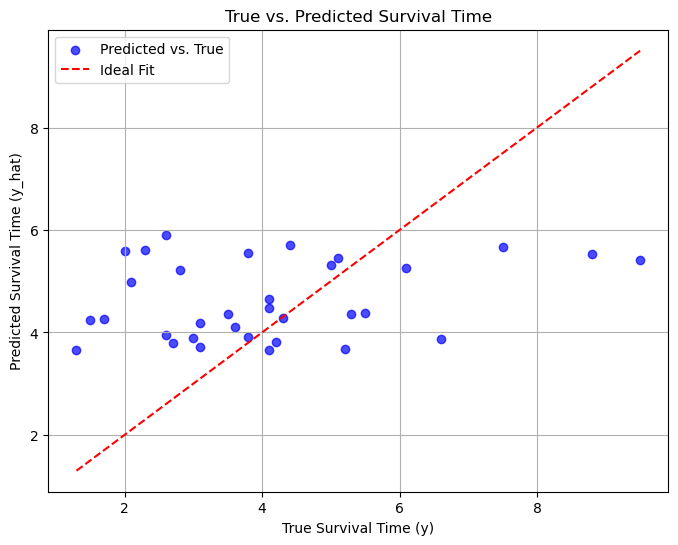

In [ ]:
def y_y_hat_plot(y, y_hat):

    # Plot the predicted vs. true survival time
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_hat, alpha=0.7, label="Predicted vs. True", color="blue")
    plt.plot([min(y), max(y)], [min(y), max(y)], '--', color="red", label="Ideal Fit")
    plt.xlabel("True Survival Time (y)")
    plt.ylabel("Predicted Survival Time (y_hat)")
    plt.title("True vs. Predicted Survival Time")
    plt.legend()
    plt.grid(True)
    plt.show()

y_y_hat_plot(y_test, y_test_pred)

In [ ]:
X_test_kaggle = pd.read_csv("test_data.csv")

# Save the id column for the submission
id = X_test_kaggle["id"]
# Drop the columns that are not used in the model
X_test_kaggle = X_test_kaggle.drop(columns=["id", "ComorbidityIndex", "GeneticRisk", "TreatmentResponse"])
# Make predictions on the test set
y_pred_kaggle = pipeline.predict(X_test_kaggle)

submission = pd.DataFrame({"id": id, "TARGET": y_pred_kaggle})

submission.to_csv("baseline-submission-02.csv", index=False)

## 1.3 Baseline with gradient descent

In [ ]:
X_uc, y_uc = prepare_xy(filt_data)

X_train_uc, X_test_uc, y_train_uc, y_test_uc, c_train_uc, c_test_uc = split_data(X_uc, y_uc)

In [ ]:

def gradient_descent(X, y, c, lr=0.01, epochs=100, reg_type=None, reg_lambda=0.01):

    # Ensure X is a 2D array and y is a 1D array
    X = np.array(X)
    y = np.array(y).flatten()

    # Standardize the input features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    m, n = X.shape
    w = np.zeros(n)  # Initialize weights
    b = 0  # Initialize bias


    for epoch in range(epochs):
        # Predicted value
        y_hat = np.dot(X, w) + b

        # Error
        err = y - y_hat

        # Indicator function: 1 if err > 0, else 0
        indicator = (err > 0).astype(float)

        # Partial derivatives
        partial_w = -2 * np.dot(X.T, err * ((1 - c) + c * indicator)) / m
        partial_b = -2 * np.sum(err * ((1 - c) + c * indicator)) / m


        # Add regularization
        if reg_type == 'lasso':
            partial_w += reg_lambda * np.sign(w) / m
        elif reg_type == 'ridge':
            partial_w += reg_lambda * 2 * w / m

        # Update weights and bias
        w -= lr * partial_w
        b -= lr * partial_b

        # Compute loss for monitoring
        loss = np.mean((1 - c) * err**2 + c * np.maximum(0, err)**2)


        # Print progress (optional)
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: w = {w}, b = {b:.4f}, loss = {loss:.6f}")


    # Rescale weights and bias to the original data scale
    w_original = w / scaler_X.scale_
    b_original = b - np.dot(scaler_X.mean_ / scaler_X.scale_, w)
    b_original = b_original * scaler_y.scale_ + scaler_y.mean_
    w_original *= scaler_y.scale_

    return w_original, b_original


weights, bias = gradient_descent(X_train_uc, y_train_uc, c_train_uc, lr=0.01, epochs=1000, reg_type="ridge", reg_lambda=0.01)

weights, bias




Epoch 0: w = [ 0.00114563 -0.00118795  0.00033129  0.00483572], b = 0.0020, loss = 0.910864
Epoch 100: w = [ 0.04781052 -0.04296813  0.0027079   0.23792336], b = 0.1046, loss = 0.824570
Epoch 200: w = [ 0.05415405 -0.04500627 -0.00209721  0.28559005], b = 0.1289, loss = 0.821008
Epoch 300: w = [ 0.05541043 -0.04449783 -0.00352828  0.29579323], b = 0.1347, loss = 0.820836
Epoch 400: w = [ 0.05571522 -0.04419925 -0.00384944  0.29799782], b = 0.1360, loss = 0.820828
Epoch 500: w = [ 0.05579805 -0.04409326 -0.00391235  0.29847796], b = 0.1364, loss = 0.820827
Epoch 600: w = [ 0.05582124 -0.0440605  -0.00392331  0.2985831 ], b = 0.1364, loss = 0.820827
Epoch 700: w = [ 0.05582771 -0.04405097 -0.00392491  0.29860622], b = 0.1364, loss = 0.820827
Epoch 800: w = [ 0.05582949 -0.04404829 -0.00392504  0.29861132], b = 0.1365, loss = 0.820827
Epoch 900: w = [ 0.05582998 -0.04404755 -0.00392502  0.29861245], b = 0.1365, loss = 0.820827
Epoch 999: w = [ 0.05583011 -0.04404735 -0.003925    0.2986127

(array([ 0.01189672, -0.18780769, -0.00783878,  1.2478752 ]),
 array([3.59729712]))

In [ ]:
X_train_gd = np.array(X_train_uc)
y_train_gd = np.array(y_train_uc).flatten()
c_train_gd = np.array(c_train_uc).flatten()


y_hat_gd = np.dot(X_train_gd, weights) + bias


# Compute the cMSE

cmse = error_metric(y_train_gd, y_hat_gd, c_train_gd)

# Evaluate cMSE on the training set
print(f"Training cMSE: {cmse}")



Training cMSE: 3.5520881015241668


In [ ]:
X_test_gd = np.array(X_test_uc)
y_test_gd = np.array(y_test_uc).flatten()
c_test_gd = np.array(c_test_uc).flatten()


y_hat_gd_test = np.dot(X_test_gd, weights) + bias


# Compute the cMSE

cmse = error_metric(y_test_gd, y_hat_gd_test, c_test_gd)

# Evaluate cMSE on the test set
print(f"Test cMSE: {cmse}")

Test cMSE: 1.8460717908309618


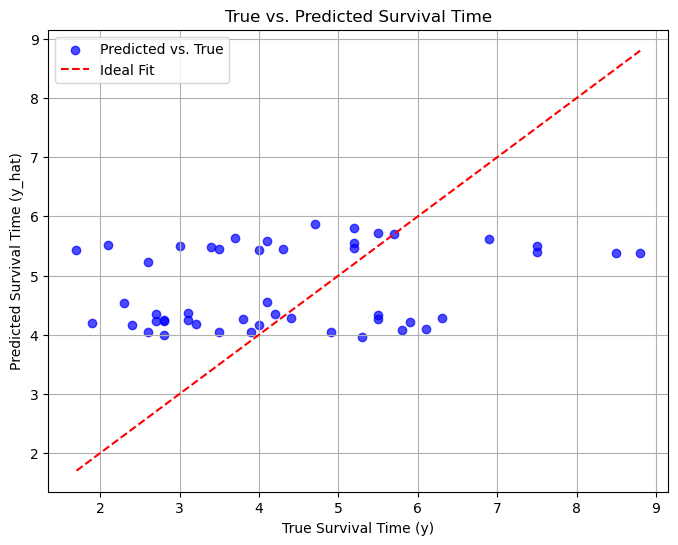

In [ ]:
y_y_hat_plot(y_test_uc, y_hat_gd_test)

In [ ]:
X_test_kaggle_gd = np.array(X_test_kaggle)

# Make predictions on the test set

y_pred_kaggle_gd_test = np.dot(X_test_kaggle_gd, weights) + bias




submission = pd.DataFrame({"id": id, "TARGET": y_pred_kaggle_gd_test})

submission.to_csv("cMSE-baseline-submission-02.csv", index=False)

## 2.1 & 2.2

### Polynomial regression

fitting degree 1 with 5 features...
C-Val cMSE: 4.5141608259119295
C-Val cMSE (std):0.7025995980707501
Test cMSE: 3.730348760873517
fitting degree 2 with 15 features...
C-Val cMSE: 4.721607373516426
C-Val cMSE (std):0.593305647661895
Test cMSE: 3.6040606942003


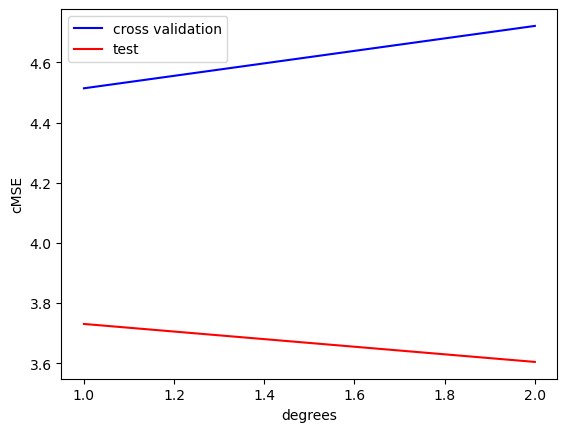

In [ ]:
# Pipeline with a StandardScaler and LinearRegression
regressor = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV())
])


def validate_poly_regression(X_train, y_train, X_test, y_test, c_train, c_test, regressor=regressor, degrees=range(1,15)):

    cv_cmses, test_cmses = [], []
    degrees = list(degrees)


    # Initialize a k-fold cross-validation with 5 folds
    kf = KFold(n_splits=5, shuffle=True)


    for i in degrees:
        poly = PolynomialFeatures(degree=i)

        poly_X_train = poly.fit_transform(X_train)
        y_train = np.array(y_train)
        c_train = np.array(c_train)

        print(f"fitting degree {i} with {poly_X_train.shape[-1]} features...")

        cv_cMSE_mean, cv_cMSE_std = Cross_val(regressor, poly_X_train, y_train, c_train, n_splits=5)
        cv_cmses.append(cv_cMSE_mean)

        print(f"C-Val cMSE: {cv_cMSE_mean}")
        print(f"C-Val cMSE (std):{cv_cMSE_std}")


        # Train the model on the full training data
        regressor.fit(poly_X_train, y_train)

        poly_X_test = poly.transform(X_test)

        # Evaluate the model on the test set
        y_test_pred = regressor.predict(poly_X_test)
        test_cMSE = error_metric(y_test, y_test_pred, c_test)
        test_cmses.append(test_cMSE)
        print(f"Test cMSE: {test_cMSE}")


    plt.plot(degrees, cv_cmses, color='blue')
    plt.plot(degrees, test_cmses, color='red')
    plt.legend(['cross validation', 'test'])
    plt.xlabel('degrees')
    plt.ylabel('cMSE')
    plt.show()

    # # Make predictions on the kaggle test set

    # poly_X_test_kaggle = poly.transform(X_test_kaggle)

    # y_pred_kaggle_poly_test = regressor.predict(poly_X_test_kaggle)

    # submission = pd.DataFrame({"id": id, "TARGET": y_pred_kaggle_poly_test})

    # submission.to_csv("Nonlinear-submission-04.csv", index=False)

validate_poly_regression(X_train, y_train, X_test, y_test, c_train, c_test, regressor=regressor, degrees=range(1,3))


### KNN

C-Val cMSE: 5.6762545142857155
C-Val cMSE (std): 2.0538407519800215
Test Set cMSE: 5.3907878787878785


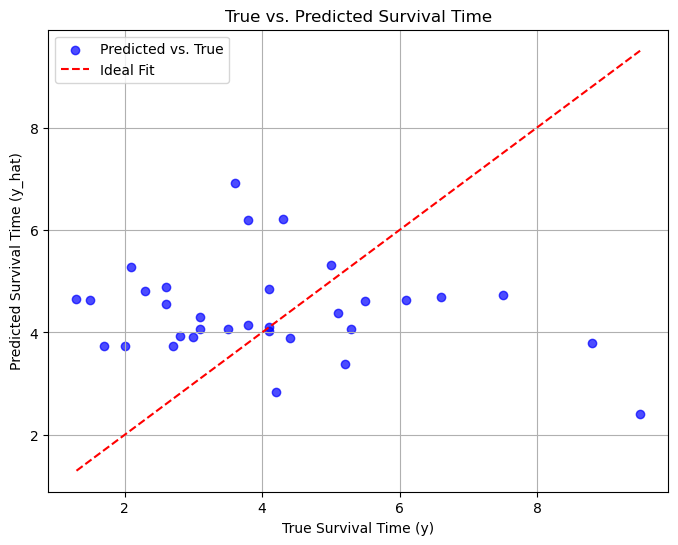

In [ ]:


# Define the k-NN function with cross-validation
def k_nn_with_cv(X_train, y_train, X_test, y_test, c_train, c_test, k=5, n_splits=5):

    # Initialize the k-NN model
    knn_model = KNeighborsRegressor(n_neighbors=k)

    cv_cMSE_mean, cv_cMSE_std = Cross_val(knn_model, X_train, y_train, c_train, n_splits=5)

    # Fit the model on the full training set
    knn_model.fit(X_train, y_train)

    # Make predictions on the test set
    prediction_test = knn_model.predict(X_test)

    # Calculate the test cMSE
    test_cMSE = error_metric(y_test, prediction_test, c_test)


    # Make predictions on the kaggle test set

    # y_pred_kaggle_knn_test = knn_model.predict(X_test_kaggle)

    # submission = pd.DataFrame({"id": id, "TARGET": y_pred_kaggle_knn_test})

    # submission.to_csv("Nonlinear-submission-02.csv", index=False)



    return cv_cMSE_mean, test_cMSE, cv_cMSE_std, prediction_test



# Apply the k-NN function
cv_cMSE_knn, test_cMSE_knn, cv_cMSE_std_knn, y_test_pred_knn= k_nn_with_cv(X_train, y_train, X_test, y_test, c_train, c_test, k=5)

# Display the results
print(f"C-Val cMSE: {cv_cMSE_knn}")
print(f"C-Val cMSE (std): {cv_cMSE_std_knn}")
print(f"Test Set cMSE: {test_cMSE_knn}")

y_y_hat_plot(y_test, y_test_pred_knn)

## 3.1

### Imputation of missing data with SimpleImputer

In [ ]:
# Split the data into training and test sets, in order to impute missing values only in the training set
data_train, data_test= train_test_split(raw_data, test_size=0.2, random_state=43)

data_train = data_train.drop(columns=["id"])

data_test = data_test.drop(columns=["id"])


# Identify missing data
missing_summary = data_train.isnull().sum()
print("Missing data summary before imputation:\n", missing_summary)

# Create a copy of the train dataset for imputation
data_imputed_s = data_train.copy()
data_imputed_s_test = data_test.copy()

#drop the rows with missing survival time
data_imputed_s = data_imputed_s.dropna(subset=["SurvivalTime"])
data_imputed_s_test = data_imputed_s_test.dropna(subset=["SurvivalTime"])

# Determine categorical columns based on the number of unique values
threshold = 4  # Assuming <= 4 unique values indicates categorical
categorical_cols = [col for col in data_imputed_s.columns if data_imputed_s[col].nunique() <= threshold]

print("\nCategorical columns detected:", categorical_cols)

# Impute categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
data_imputed_s[categorical_cols] = categorical_imputer.fit_transform(data_imputed_s[categorical_cols])


# transform the test data
data_imputed_s_test[categorical_cols] = categorical_imputer.transform(data_imputed_s_test[categorical_cols])



# Verify there are no more missing values in the imputed dataset
missing_summary_after = data_imputed_s.isnull().sum()
print("\nMissing data summary after imputation in data_imputed:\n", missing_summary_after)

# Display the first few rows of the imputed dataset
data_imputed_s.head(100)

Missing data summary before imputation:
 Age                    0
Gender                 0
Stage                  0
GeneticRisk           69
TreatmentType          0
ComorbidityIndex      38
TreatmentResponse     22
SurvivalTime         134
Censored               0
dtype: int64

Categorical columns detected: ['Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse', 'Censored']

Missing data summary after imputation in data_imputed:
 Age                  0
Gender               0
Stage                0
GeneticRisk          0
TreatmentType        0
ComorbidityIndex     0
TreatmentResponse    0
SurvivalTime         0
Censored             0
dtype: int64


,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
195,76.0,1.0,3.0,0.0,0.0,0.0,1.0,2.2,1.0
26,68.0,0.0,4.0,0.0,1.0,1.0,0.0,5.1,0.0
177,68.0,1.0,4.0,0.0,0.0,1.0,1.0,3.2,0.0
214,53.0,1.0,1.0,0.0,1.0,0.0,1.0,6.3,1.0
337,77.0,1.0,3.0,0.0,0.0,2.0,0.0,3.4,1.0
...,...,...,...,...,...,...,...,...,...
116,70.0,1.0,3.0,0.0,0.0,1.0,0.0,2.8,0.0
153,67.0,0.0,3.0,0.0,1.0,1.0,0.0,6.9,0.0
43,60.0,1.0,1.0,1.0,0.0,0.0,1.0,6.4,0.0
129,74.0,1.0,4.0,0.0,1.0,0.0,0.0,3.8,0.0


In [ ]:

# Prepare the feature matrix X and target vector y
X_train_si, y_train_si = prepare_xy(data_imputed_s)
X_test_si, y_test_si = prepare_xy(data_imputed_s_test)


# Split the dataset into train and test sets
# Separate the censored column
c_train_si = X_train_si["Censored"]
c_test_si = X_test_si["Censored"]
X_train_si = X_train_si.drop(columns=["Censored"])
X_test_si = X_test_si.drop(columns=["Censored"])

# print the shapes of the training and test sets
X_train_si.shape, X_test_si.shape, y_train_si.shape, y_test_si.shape

((186, 7), (54, 7), (186,), (54,))

### Imputation of missing data with IterativeImputer

In [ ]:
data_train, data_test= train_test_split(raw_data, test_size=0.2, random_state=43)

data_train = data_train.drop(columns=["id"])

data_test = data_test.drop(columns=["id"])


# Identify missing data
missing_summary = data_train.isnull().sum()
print("Missing data summary before imputation:\n", missing_summary)

# Create a copy of the train dataset for imputation
data_imputed = data_train.copy()
data_imputed_test = data_test.copy()

# drop rows with missing survival time
data_imputed = data_imputed.dropna(subset=["SurvivalTime"])
data_imputed_test = data_imputed_test.dropna(subset=["SurvivalTime"])

# Determine categorical columns based on the number of unique values
threshold = 4  # Assuming <= 4 unique values indicates categorical
categorical_cols = [col for col in data_imputed.columns if data_imputed[col].nunique() <= threshold]


print("\nCategorical columns detected:", categorical_cols)


# Impute categorical columns first with the IterativeImputer
iterative_imputer = IterativeImputer(max_iter=10)
data_imputed[categorical_cols] = iterative_imputer.fit_transform(data_imputed[categorical_cols])


# round the imputed categorical values
data_imputed[categorical_cols] = np.round(data_imputed[categorical_cols])
# clamp the imputed categorical values to the maximum value, keeping the range the same as the original data
data_imputed[categorical_cols] = np.minimum(data_imputed[categorical_cols], np.broadcast_to(data_train[categorical_cols].max(), data_imputed[categorical_cols].shape))



# transform the test data
data_imputed_test[categorical_cols] = iterative_imputer.transform(data_imputed_test[categorical_cols])
data_imputed_test[categorical_cols] = np.round(data_imputed_test[categorical_cols])
data_imputed_test[categorical_cols] = np.minimum(data_imputed_test[categorical_cols], np.broadcast_to(data_train[categorical_cols].max(), data_imputed_test[categorical_cols].shape))



# Verify there are no more missing values in the imputed dataset
missing_summary_after = data_imputed.isnull().sum()
print("\nMissing data summary after imputation in data_imputed:\n", missing_summary_after)

# Display the first few rows of the imputed dataset
data_imputed.head()

# assert same ranges for the imputed data
assert data_imputed.min().all() == data_train.min().all()
assert data_imputed.max().all() == data_train.max().all()

# describe the imputed data
print(data_imputed.head(100))




Missing data summary before imputation:
 Age                    0
Gender                 0
Stage                  0
GeneticRisk           69
TreatmentType          0
ComorbidityIndex      38
TreatmentResponse     22
SurvivalTime         134
Censored               0
dtype: int64

Categorical columns detected: ['Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse', 'Censored']

Missing data summary after imputation in data_imputed:
 Age                  0
Gender               0
Stage                0
GeneticRisk          0
TreatmentType        0
ComorbidityIndex     0
TreatmentResponse    0
SurvivalTime         0
Censored             0
dtype: int64
      Age  Gender  Stage  GeneticRisk  TreatmentType  ComorbidityIndex  \
195  76.0     1.0    3.0          0.0            0.0               0.0   
26   68.0     0.0    4.0          0.0            1.0               1.0   
177  68.0     1.0    4.0          0.0            0.0               1.0   
214  53.0   

In [ ]:
# describe the original data
data_train.describe()
data_imputed.head()


,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
195,76.0,1.0,3.0,0.0,0.0,0.0,1.0,2.2,1.0
26,68.0,0.0,4.0,0.0,1.0,1.0,0.0,5.1,0.0
177,68.0,1.0,4.0,0.0,0.0,1.0,1.0,3.2,0.0
214,53.0,1.0,1.0,0.0,1.0,0.0,1.0,6.3,1.0
337,77.0,1.0,3.0,0.0,0.0,2.0,0.0,3.4,1.0


In [ ]:


# Prepare the feature matrix X and target vector y
X_train_i, y_train_i = prepare_xy(data_imputed)
X_test_i, y_test_i = prepare_xy(data_imputed_test)


# Split the dataset into train and test sets
# Separate the censored column
c_train_i = X_train_i["Censored"]
c_test_i = X_test_i["Censored"]
X_train_i = X_train_i.drop(columns=["Censored"])
X_test_i = X_test_i.drop(columns=["Censored"])

# print the shapes of the training and test sets
X_train_i.shape, X_test_i.shape, y_train_i.shape, y_test_i.shape



((186, 7), (54, 7), (186,), (54,))

{'Cross-Validation cMSE (mean)': 2.2965835211293575, 'Cross-Validation cMSE (std)': 0.8902567004363314, 'Test Set cMSE': 3.6931838006805284, 'Training Data Points': 186, 'Test Data Points': 54}


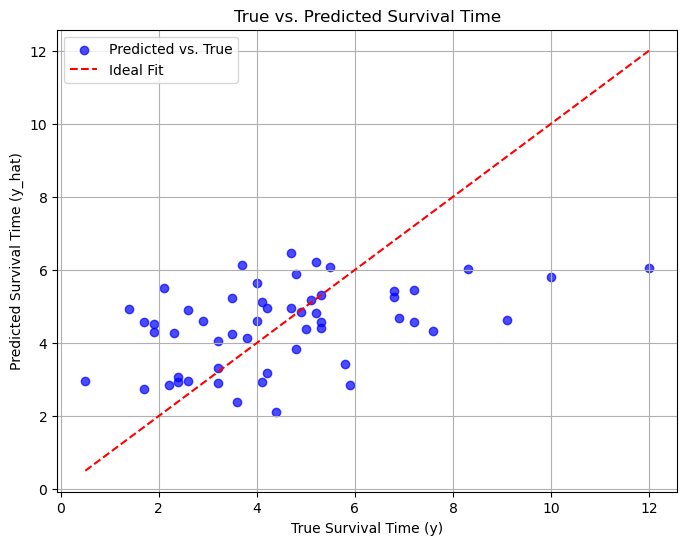

In [ ]:
# Pipeline with a StandardScaler and LinearRegression
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Apply the baseline model to the imputed dataset
y_test_pred_i, impu_baseline_results = baseline_model(pipeline2, X_train_i, y_train_i, X_test_i, y_test_i, c_train_i, c_test_i)
print(impu_baseline_results)

y_y_hat_plot(y_test_i, y_test_pred_i)

### imputation of missing data with knn imputer (better)

In [ ]:
from sklearn.impute import KNNImputer


# Create a copy of the train dataset for imputation
data_imputed_knn = data_train.copy()
data_imputed_test_knn = data_test.copy()

# drop rows with missing survival time
data_imputed_knn = data_imputed_knn.dropna(subset=["SurvivalTime"])
data_imputed_test_knn = data_imputed_test_knn.dropna(subset=["SurvivalTime"])



categorical_cols = [col for col in data_imputed_knn.columns if data_imputed_knn[col].nunique() <= threshold]


print("\nCategorical columns detected:", categorical_cols)

# Apply nn imputation to the categorical columns
knn_imputer = KNNImputer(n_neighbors=3)
data_imputed_knn[categorical_cols] = knn_imputer.fit_transform(data_imputed_knn[categorical_cols])

data_imputed_knn[categorical_cols] = np.round(data_imputed_knn[categorical_cols])
data_imputed_knn[categorical_cols] = np.minimum(data_imputed_knn[categorical_cols], np.broadcast_to(data_train[categorical_cols].max(), data_imputed_knn[categorical_cols].shape))


# transform the test data
data_imputed_test_knn[categorical_cols] = knn_imputer.transform(data_imputed_test_knn[categorical_cols])
data_imputed_test_knn[categorical_cols] = np.round(data_imputed_test_knn[categorical_cols])
data_imputed_test_knn[categorical_cols] = np.minimum(data_imputed_test_knn[categorical_cols], np.broadcast_to(data_train[categorical_cols].max(), data_imputed_test_knn[categorical_cols].shape))



# describe the imputed data
data_imputed_knn.describe()



Categorical columns detected: ['Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse', 'Censored']


,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.00000,186.000000,186.000000
mean,64.516129,0.591398,2.655914,0.258065,0.467742,1.032258,0.50000,4.464516,0.333333
std,9.570916,0.492902,1.075472,0.438751,0.500305,0.818061,0.50135,1.945314,0.472677
min,40.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.800000,0.000000
25%,58.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,3.000000,0.000000
50%,65.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.50000,4.100000,0.000000
75%,70.000000,1.000000,4.000000,1.000000,1.000000,2.000000,1.00000,5.700000,1.000000
max,90.000000,1.000000,4.000000,1.000000,1.000000,3.000000,1.00000,12.100000,1.000000


In [ ]:
# describe the original data
data_train.describe()

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
count,320.00000,320.000000,320.000000,251.000000,320.000000,282.000000,298.000000,186.000000,320.000000
mean,65.11875,0.581250,2.593750,0.278884,0.409375,1.120567,0.500000,4.464516,0.193750
std,9.16609,0.494127,1.098856,0.449347,0.492489,0.888641,0.500841,1.945314,0.395854
min,40.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000
25%,59.00000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,65.00000,1.000000,3.000000,0.000000,0.000000,1.000000,0.500000,4.100000,0.000000
75%,72.00000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,5.700000,0.000000
max,90.00000,1.000000,4.000000,1.000000,1.000000,3.000000,1.000000,12.100000,1.000000


In [ ]:
# Prepare the feature matrix X and target vector y
X_train_ki, y_train_ki = prepare_xy(data_imputed_knn)
X_test_ki, y_test_ki = prepare_xy(data_imputed_test_knn)


# Split the dataset into train and test sets
# Separate the censored column
c_train_ki = X_train_ki["Censored"]
c_test_ki = X_test_ki["Censored"]
X_train_ki = X_train_ki.drop(columns=["Censored"])
X_test_ki = X_test_ki.drop(columns=["Censored"])

# print the shapes of the training and test sets
X_train_ki.shape, X_test_ki.shape, y_train_ki.shape, y_test_ki.shape


((186, 7), (54, 7), (186,), (54,))

{'Cross-Validation cMSE (mean)': 2.2703520098598986, 'Cross-Validation cMSE (std)': 0.4494767964237073, 'Test Set cMSE': 3.3240976444561863, 'Training Data Points': 186, 'Test Data Points': 54}


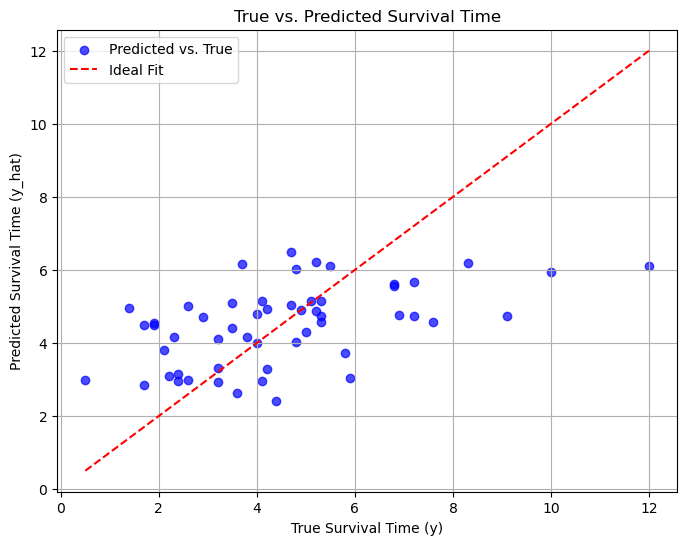

In [ ]:
# Pipeline with a StandardScaler and LinearRegression
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Apply the baseline model to the imputed dataset
y_test_pred_ki, impuk_baseline_results = baseline_model(pipeline3, X_train_ki, y_train_ki, X_test_ki, y_test_ki, c_train_ki, c_test_ki)
print(impuk_baseline_results)

y_y_hat_plot(y_test_ki, y_test_pred_ki)

### KNN model performance with imputed data from KNNImputer

C-Val cMSE: 3.340096728307254
C-Val cMSE (std): 0.5471621658218007
Test Set cMSE: 5.40311111111111


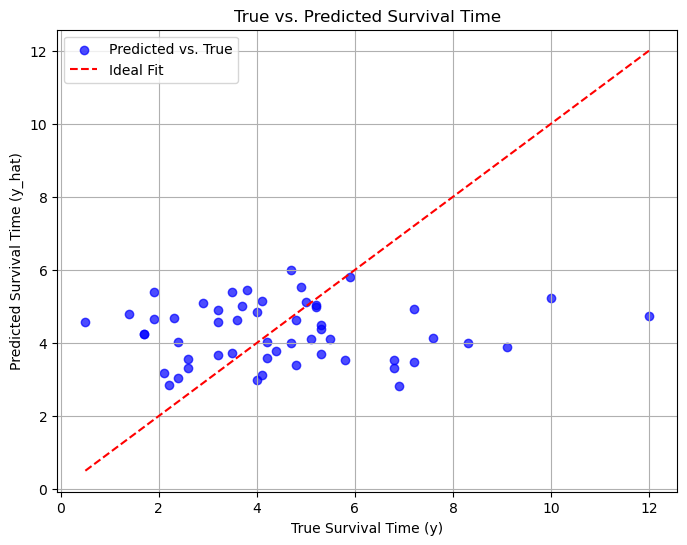

In [ ]:
# Apply the k-NN function to the imputed dataset
cv_cMSE_knn_i, test_cMSE_knn_i, cv_cMSE_std_knn_i, y_test_pred_knn_i= k_nn_with_cv(X_train_ki, y_train_ki, X_test_ki, y_test_ki, c_train_ki, c_test_ki, k=5)

# Display the results
print(f"C-Val cMSE: {cv_cMSE_knn_i}")
print(f"C-Val cMSE (std): {cv_cMSE_std_knn_i}")
print(f"Test Set cMSE: {test_cMSE_knn_i}")

y_y_hat_plot(y_test_ki, y_test_pred_knn_i)



### Polynomial regression with imputed data from KNNImputer

fitting degree 1 with 8 features...
C-Val cMSE: 2.2669500478338316
C-Val cMSE (std):0.42050520491124316
Test cMSE: 3.3515489958710636
fitting degree 2 with 36 features...
C-Val cMSE: 2.5718370683626777
C-Val cMSE (std):0.35493293982236335
Test cMSE: 3.200261071300377


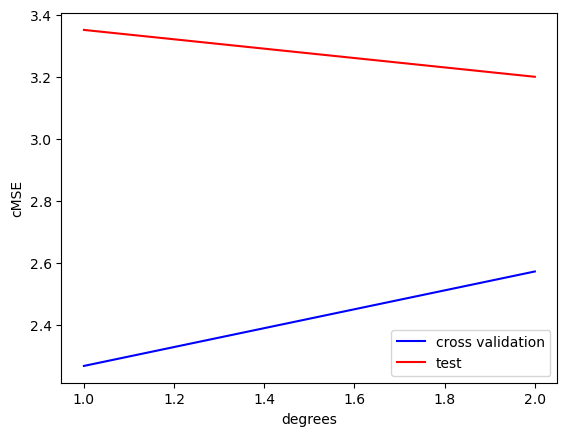

In [ ]:
regressor2 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV())
])
# Apply the polynomial regression function to the imputed dataset
validate_poly_regression(X_train_ki, y_train_ki, X_test_ki, y_test_ki, c_train_ki, c_test_ki, regressor=regressor2, degrees=range(1,3))

## 3.2

In [ ]:
tree_data = raw_data.drop(columns=["id"])

tree_data = tree_data.dropna(subset=["SurvivalTime"])

X_tree, y_tree = prepare_xy(tree_data)

X_train_t, X_test_t, y_train_t, y_test_t, c_train_t, c_test_t = split_data(X_tree, y_tree)

### HistGradientBoostingRegressor

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
def gradient_boosting_with_cv(X_train, X_test, y_train, y_test, c_train, c_test, n_splits=5):


    # Initialize the HistGradientBoostingRegressor model
    hgb_regressor = HistGradientBoostingRegressor(max_iter=1000, max_depth=15, learning_rate=0.001)

    cv_cMSE_mean, cv_cMSE_std = Cross_val(hgb_regressor, X_train, y_train, c_train, n_splits=5)

    # Fit the model on the full training set
    hgb_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    prediction_test = hgb_regressor.predict(X_test)

    # Calculate the test cMSE
    test_cMSE = error_metric(y_test, prediction_test, c_test)


    return cv_cMSE_mean, test_cMSE, cv_cMSE_std, prediction_test

# Apply the gradient boosting function
cv_cMSE_hgb, test_cMSE_hgb, cv_cMSE_std_hgb, y_test_pred_hgb = gradient_boosting_with_cv(X_train_t, X_test_t, y_train_t, y_test_t, c_train_t, c_test_t)

# Display the results
print(f"C-Val cMSE: {cv_cMSE_hgb}")
print(f"C-Val cMSE (std): {cv_cMSE_std_hgb}")
print(f"Test Set cMSE: {test_cMSE_hgb}")




C-Val cMSE: 3.007837573573016
C-Val cMSE (std): 1.0311704266596713
Test Set cMSE: 1.5312976475089304


### CatBoostRegressor

In [ ]:
from catboost import CatBoostRegressor

def catboost_with_cv(X_train, X_test, y_train, y_test, c_train, c_test, n_splits=5):


    # Initialize the CatBoostRegressor model
    catboost_regressor = CatBoostRegressor(iterations=1000, depth=15, learning_rate=0.001, verbose=0)

    # Define K-Fold cross-validation
    cv_cMSE_mean, cv_cMSE_std = Cross_val(catboost_regressor, X_train, y_train, c_train, n_splits=5)

    # Fit the model on the full training set
    catboost_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    prediction_test = catboost_regressor.predict(X_test)

    # Calculate the test cMSE
    test_cMSE = error_metric(y_test, prediction_test, c_test)

    return cv_cMSE_mean, test_cMSE, cv_cMSE_std, prediction_test


# Apply the CatBoost function
cv_cMSE_cat, test_cMSE_cat, cv_cMSE_std_cat, y_test_pred_cat = catboost_with_cv(X_train_t, X_test_t, y_train_t, y_test_t, c_train_t, c_test_t)

# Display the results
print(f"C-Val cMSE: {cv_cMSE_cat}")
print(f"C-Val cMSE (std): {cv_cMSE_std_cat}")
print(f"Test Set cMSE: {test_cMSE_cat}")


C-Val cMSE: 3.3870927485170363
C-Val cMSE (std): 0.9525358331583041
Test Set cMSE: 1.6611315963832585


### CatBoostRegressor with SurvivalAft

In [ ]:
from catboost import CatBoostRegressor, Pool


def catboost_survival(data, iter, depth, lr):

    data = data.copy()
    data = data.dropna(subset=["SurvivalTime"])

    # Prepare the data
    data['y_lower'] = data['SurvivalTime']
    data['y_upper'] = np.where(data['Censored'], -1,data['SurvivalTime'])
    # Drop unnecessary columns for modeling
    # data = data.drop(['id'], axis=1)
    data = data.drop(['SurvivalTime'], axis=1)

    train, test = train_test_split(data, test_size=0.2, stratify=data['Censored'],random_state=32)

    c_train = train["Censored"]
    c_test = test["Censored"]
    test = test.drop(["Censored"], axis=1)
    train = train.drop(["Censored"], axis=1)


    # Define features and categorical features
    features = train.columns.difference(['y_lower', 'y_upper'], sort=False)
    cat_features = ['Age','Gender', 'Stage', 'GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse', 'TreatmentType']

    for cat_feature in cat_features:
        train[cat_feature] = train[cat_feature].astype(str)
        test[cat_feature] = test[cat_feature].astype(str)

    # Create CatBoost Pool objects
    train_pool = Pool(train[features], label=train[['y_lower', 'y_upper']], cat_features=cat_features)
    test_pool = Pool(test[features], label=test[['y_lower', 'y_upper']], cat_features=cat_features)

    # Train CatBoost models
    model_normal = CatBoostRegressor(
        iterations=iter,
        depth=depth, learning_rate=lr,
        loss_function='SurvivalAft:dist=Normal',
        eval_metric='SurvivalAft',
        verbose=0
    )

    model_normal.fit(train_pool, eval_set=test_pool)

    # Make predictions
    train_predictions = pd.DataFrame({
        'y_lower': train['y_lower'],
        'y_upper': np.where(train['y_upper'] == -1, np.inf, train['y_upper']),
        'preds_normal': model_normal.predict(train_pool, prediction_type='Exponent')
    })

    test_predictions = pd.DataFrame({
        'y_lower': test['y_lower'],
        'y_upper': np.where(test['y_upper'] == -1, np.inf, test['y_upper']),
        'preds_normal': model_normal.predict(test_pool, prediction_type='Exponent')
    })


    y_test = test_predictions['y_lower']
    y_hat_test = test_predictions['preds_normal']

    cmse = error_metric(y_test, y_hat_test, c_test)

    return cmse, model_normal, test_predictions



### Greedy search to find the best parameters for CatBoost with Survival Aft

In [ ]:
from itertools import product

# best_params = None
# best_cmse = float('inf')
# best_predictions = None
# best_model = None

# iterations = [1000]
# depths = list(range(4, 16))
# lrs = [0.01, 0.05 ,0.1]
# # data: data_train; data_imputed; data_imputed_knn
# for iteration, depth, lr in product(iterations, depths, lrs):
#     cmse, model, test_predictions = catboost_survival(data_imputed, iteration, depth, lr)
#     print(f'Iterations: {iteration}, Depth: {depth}, Learning Rate: {lr}, Val cMSE: {cmse:.2f}')

#     if cmse < best_cmse:
#         best_cmse = cmse
#         best_params = (iteration, depth, lr)
#         best_predictions = test_predictions
#         best_model = model

# print(f'Best Parameters: Iterations={best_params[0]}, Depth={best_params[1]}, Learning Rate={best_params[2]}')
# print(f'Best Test cMSE: {best_cmse:.2f}')


########### RESULTS #######
# Best Parameters: Iterations=1000, Depth=9, Learning Rate=0.05
# Best Test cMSE: 2.25





In [ ]:
def catboost_pred(model, data):
    data = data.copy()
    data = data.dropna(subset=["SurvivalTime"])
    # Prepare the data
    data['y_lower'] = data['SurvivalTime']
    data['y_upper'] = np.where(data['Censored'], -1,data['SurvivalTime'])
    # Drop unnecessary columns for modeling
    data = data.drop(['SurvivalTime'], axis=1)

    c = data["Censored"]
    data = data.drop(["Censored"], axis=1)

    # Define features and categorical features
    features = data.columns.difference(['y_lower', 'y_upper'], sort=False)
    cat_features = ['Age','Gender', 'Stage', 'GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse', 'TreatmentType']


    for cat_feature in cat_features:
        data[cat_feature] = data[cat_feature].astype(str)

    # Create CatBoost Pool objects
    data_pool = Pool(data[features], label=data[['y_lower', 'y_upper']], cat_features=cat_features)

    # Make predictions
    predictions = pd.DataFrame({
        'y_lower': data['y_lower'],
        'y_upper': np.where(data['y_upper'] == -1, np.inf, data['y_upper']),
        'preds_normal': model.predict(data_pool, prediction_type='Exponent')
    })

    y_test = predictions['y_lower']
    y_hat_test = predictions['preds_normal']

    cmse = error_metric(y_test, y_hat_test, c)


    return cmse, predictions

### Predictions

In [ ]:

val_cmse, model, val_predictions = catboost_survival(data_imputed, iter = 1000, depth = 9, lr = 0.05)

print(f'Validation cMSE: {val_cmse:.2f}')


test_cmse, test_predictions = catboost_pred(model, data_test)

print(f'Test cMSE: {test_cmse:.2f}')

Validation cMSE: 1.53
Test cMSE: 3.89


Test cMSE: 3.885288638629681


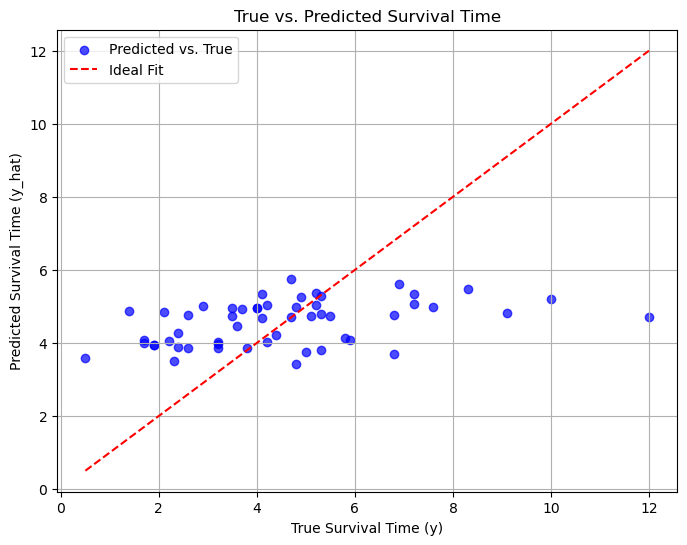

In [ ]:

# Extract the true survival time (y_lower) and predicted survival time
y_test = test_predictions['y_lower']
y_hat_test = test_predictions['preds_normal']

print(f"Test cMSE: {test_cmse}")

# Call the function to create the plot
y_y_hat_plot(y_test, y_hat_test)



## 3.3

### Gradient Boosting on imputed data from KNNImputer

C-Val cMSE: 2.58819783137534
C-Val cMSE (std): 0.6968284630604302
Test Set cMSE: 3.5447978167163345


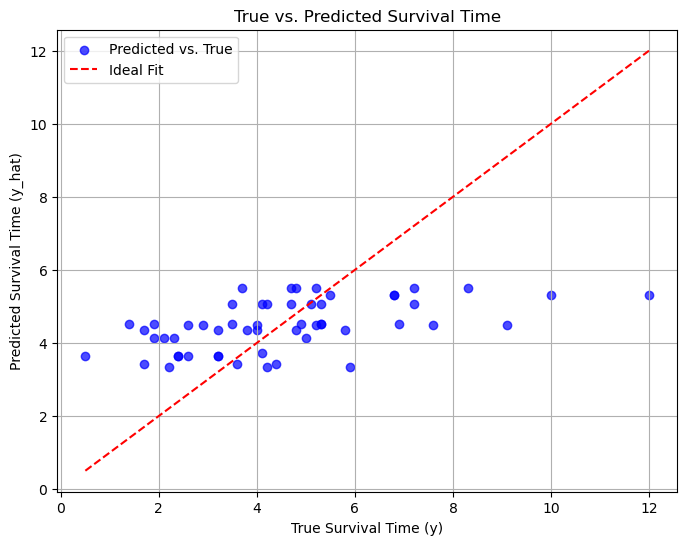

In [ ]:


# Apply the gradient boosting function
cv_cMSE_hgb, test_cMSE_hgb, cv_cMSE_std_hgb, y_test_pred_hgb = gradient_boosting_with_cv(X_train_ki, X_test_ki, y_train_ki, y_test_ki, c_train_ki, c_test_ki)

# Display the results
print(f"C-Val cMSE: {cv_cMSE_hgb}")
print(f"C-Val cMSE (std): {cv_cMSE_std_hgb}")
print(f"Test Set cMSE: {test_cMSE_hgb}")

y_y_hat_plot(y_test_ki, y_test_pred_hgb)

In [ ]:
# Initialize the HistGradientBoostingRegressor model
hgb_regressor = HistGradientBoostingRegressor(max_iter=1000, max_depth=15, learning_rate=0.001)

# Fit the model on the imputed training set
hgb_regressor.fit(X_train_ki, y_train_ki)

X_test_kaggle_all = pd.read_csv("test_data.csv")
# Save the id column for the submission
id = X_test_kaggle_all["id"]
# Drop the columns that are not used in the model
X_test_kaggle_all = X_test_kaggle_all.drop(columns=["id"])


# Make predictions on the Kaggle test set
prediction_hgb_kaggle = hgb_regressor.predict(X_test_kaggle_all)


submission = pd.DataFrame({"id": id, "TARGET": prediction_hgb_kaggle})

submission.to_csv("handle-missing-submission-05.csv", index=False)

## 4.1

### KNNImputer trained on the data with and without labels

In [ ]:
from sklearn.impute import KNNImputer


# Create a copy of the train dataset for imputation
data_imputed_knn = data_train.copy()
data_imputed_test_knn = data_test.copy()

categorical_cols = [col for col in data_imputed_knn.columns if data_imputed_knn[col].nunique() <= threshold]


print("\nCategorical columns detected:", categorical_cols)

# Apply nn imputation to the categorical columns
knn_imputer = KNNImputer(n_neighbors=3)
data_imputed_knn[categorical_cols] = knn_imputer.fit_transform(data_imputed_knn[categorical_cols])

data_imputed_knn[categorical_cols] = np.round(data_imputed_knn[categorical_cols])
data_imputed_knn[categorical_cols] = np.minimum(data_imputed_knn[categorical_cols], np.broadcast_to(data_train[categorical_cols].max(), data_imputed_knn[categorical_cols].shape))

# drop rows with missing survival time after fitting the imputer
data_imputed_knn = data_imputed_knn.dropna(subset=["SurvivalTime"])

# transform the test data
data_imputed_test_knn[categorical_cols] = knn_imputer.transform(data_imputed_test_knn[categorical_cols])
data_imputed_test_knn[categorical_cols] = np.round(data_imputed_test_knn[categorical_cols])
data_imputed_test_knn[categorical_cols] = np.minimum(data_imputed_test_knn[categorical_cols], np.broadcast_to(data_train[categorical_cols].max(), data_imputed_test_knn[categorical_cols].shape))

# drop rows with missing survival time
data_imputed_test_knn = data_imputed_test_knn.dropna(subset=["SurvivalTime"])




Categorical columns detected: ['Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse', 'Censored']


### Linear regression with imputed data from KNNImputer trained on the data with and without labels

{'Cross-Validation cMSE (mean)': 2.2870530042232593, 'Cross-Validation cMSE (std)': 0.5165413652156887, 'Test Set cMSE': 3.330262412144981, 'Training Data Points': 186, 'Test Data Points': 54}


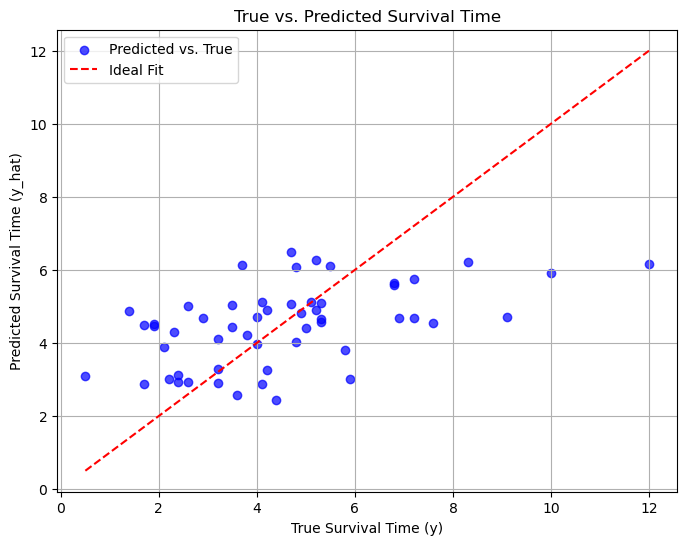

In [ ]:
# Prepare the feature matrix X and target vector y
X_train_ki, y_train_ki = prepare_xy(data_imputed_knn)
X_test_ki, y_test_ki = prepare_xy(data_imputed_test_knn)


# Split the dataset into train and test sets
# Separate the censored column
c_train_ki = X_train_ki["Censored"]
c_test_ki = X_test_ki["Censored"]
X_train_ki = X_train_ki.drop(columns=["Censored"])
X_test_ki = X_test_ki.drop(columns=["Censored"])


# Pipeline with a StandardScaler and LinearRegression
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])


y_test_pred_ki, baseline_results_ki = baseline_model(pipeline3, X_train_ki, y_train_ki, X_test_ki, y_test_ki, c_train_ki, c_test_ki)
print(baseline_results_ki)




y_y_hat_plot(y_test_ki, y_test_pred_ki)

### Isomap

In [ ]:
from sklearn.base import BaseEstimator

class FrozenTransformer(BaseEstimator):
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def __getattr__(self, name):
        # `fitted_transformer`'s attributes are now accessible
        return getattr(self.fitted_transformer, name)

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        # Fitting does not change the state of the estimator
        return self

    def transform(self, X, y=None):
        # transform only transforms the data
        return self.fitted_transformer.transform(X)

    def fit_transform(self, X, y=None):
        # fit_transform only transforms the data
        return self.fitted_transformer.transform(X)

In [ ]:
from sklearn.manifold import Isomap
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

iso_data = raw_data.copy()

iso_data = iso_data.drop(columns=["id"])

iso_train1, iso_test1 = train_test_split(iso_data, test_size=0.2, random_state=43)

iso_train = iso_train1.copy()
iso_test = iso_test1.copy()
iso_train_l = iso_train1.copy()
iso_test_l = iso_test1.copy()


# Separate the censored column for the labeled data and unsupervised data
c_train_iso = iso_train["Censored"]
c_test_iso = iso_test["Censored"]
iso_train = iso_train.drop(columns=["Censored"])
iso_test = iso_test.drop(columns=["Censored"])

# Prepare the feature matrix X and target vector y for the labeled data and unsupervised data
X_train_iso = iso_train.drop(columns=["SurvivalTime"])
y_train_iso = iso_train["SurvivalTime"]


# Drop rows with missing survival time for the labeled data
iso_train_l = iso_train_l.dropna(subset=["SurvivalTime"])
iso_test_l = iso_test_l.dropna(subset=["SurvivalTime"])

# Separate the censored column for the labeled data
c_train_iso_l = iso_train_l["Censored"]
c_test_iso_l = iso_test_l["Censored"]
iso_train_l = iso_train_l.drop(columns=["Censored"])
iso_test_l = iso_test_l.drop(columns=["Censored"])


# Prepare the feature matrix X and target vector y for the train labeled data
X_train_iso_l = iso_train_l.drop(columns=["SurvivalTime"])
y_train_iso_l = iso_train_l["SurvivalTime"]

# Prepare the feature matrix X and target vector y for the test labeled data
X_test_iso_l = iso_test_l.drop(columns=["SurvivalTime"])
y_test_iso_l = iso_test_l["SurvivalTime"]


(320, 7)
(320, 7)
C-Val cMSE: 2.3056176749235506
C-Val cMSE (std): 0.4235649802254581
Test cMSE: 3.4656167250373637


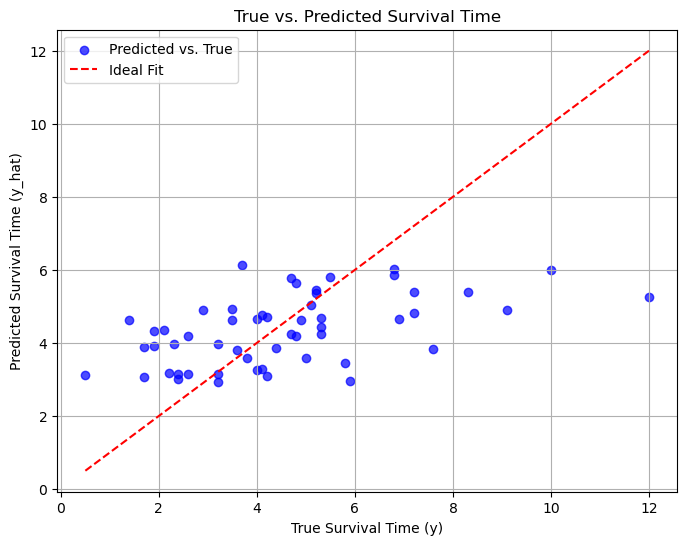

In [ ]:
# Impute missing values with the best imputers from Task 3.1
imp = KNNImputer(n_neighbors=3)

# X is the union of the unsupervised and (train) supervised feature datasets
X = imp.fit_transform(X_train_iso)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# # PCA for initial dimensionality reduction
# pca = PCA(n_components=4)  # Retain 95% of the variance (or use a fixed integer for n_components)

# X = pca.fit_transform(X)

print(X.shape)


# Try different numbers of components.
iso = Isomap(n_neighbors=8, n_components=3)
iso.fit(X)
print(X.shape)

pipe = make_pipeline(imp,
                     scaler,
                    #  pca,
                     FrozenTransformer(iso), # <- Here is the Frozen Isomap
                     LinearRegression())



iso_cv_cMSE_mean, iso_cv_cMSE_std = Cross_val(pipe, X_train_iso_l, y_train_iso_l, c_train_iso_l, n_splits=5)


# (X_train, y_train) is the labeled, supervised data
pipe.fit(X_train_iso_l, y_train_iso_l)


iso_test_pred = pipe.predict(X_test_iso_l)


iso_test_cMSE = error_metric(y_test_iso_l, iso_test_pred, c_test_iso_l)


print(f"C-Val cMSE: {iso_cv_cMSE_mean}")
print(f"C-Val cMSE (std): {iso_cv_cMSE_std}")
print(f"Test cMSE: {iso_test_cMSE}")

y_y_hat_plot(y_test_iso_l, iso_test_pred)


In [ ]:
# Make predictions on the Kaggle test set
iso_kaggle_pred = pipe.predict(X_test_kaggle_all)


submission = pd.DataFrame({"id": id, "TARGET": iso_kaggle_pred})

submission.to_csv("semisupervised-submission-05.csv", index=False)